In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataset import Dataset

import torchvision
from torchvision import datasets, transforms , models
from torchvision.models import resnet50, ResNet50_Weights , resnet18, ResNet18_Weights

from torch import nn
import torch.optim as optim

import pandas as pd
import warnings

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


In [3]:
class BoatImages(Dataset):
    def __init__(self, _label_type = "Hull Type" , root = './', train=True):
        self.img_height  = 256  
        self.img_width   = self.img_height
        self.img_height_crop = 256  
        self.img_width_crop  = self.img_height_crop
        self.tabular_data = pd.read_csv("boat_data_cleaned.csv")
        # self.name_from_path = re.compile(r'\./data/\w*\\(.+?)\\')
        self.name_from_path = re.compile(r'\./data/[^/]+/(.+?)/')

        self.train = train
        self.label_type = _label_type
        self.labels , self.categories = pd.factorize(self.tabular_data[self.label_type])

        if self.train:
            self.data_folder = os.path.join(root, 'data/train') # FIXME make a better train test split
        else:
            self.data_folder = os.path.join(root, 'data/test')

        self.dataset_train = datasets.ImageFolder(self.data_folder)

    # a getter function
    @property
    def label_type(self):
        return self._label_type
        
    # a setter function
    @label_type.setter
    def label_type(self, l):
        try:
            self._label_type = l
            self.labels , self.categories = pd.factorize(self.tabular_data[l])
        except:
            self._label_type = "Hull Type"
            self.labels , self.categories = pd.factorize(self.tabular_data[self._label_type])
            warnings.warn("Invalid label_type! Setting label_type to 'Hull Type'")



    def __getitem__(self, index):
        path, _ = self.dataset_train.samples[index]
        image = self.dataset_train.loader(path)

        image = transforms.Resize((self.img_width,self.img_height))(image)
        
        boat_name = re.match(self.name_from_path , path).group(1).replace("_"," ")
        try:
            label_idx = self.tabular_data.index[(self.tabular_data['name'].eq(boat_name))].tolist()[0]
        except:
            label_idx = self.tabular_data.index[(self.tabular_data['name'].eq(boat_name+'.'))].tolist()[0]

        label = self.labels[label_idx]


      # if self.train:
        # image = transforms.RandomAffine((-5,5))(image)
        # image = transforms.RandomCrop((self.img_width_crop, self.img_height_crop))(image)
        #image = transforms.ColorJitter(0.8, contrast = 0.4)(image)
        # image = transforms.RandomHorizontalFlip(p=0.5)(image)
      # else:
        # image = transforms.CenterCrop((self.img_width_crop, self.img_height_crop))(image)

        image = transforms.ToTensor()(image)

        # if self.transform is not None:
        #     image = self.transform(image)
        # if self.target_transform is not None:
        #     label = self.target_transform(label)

        # print(image,label)

        return image, label

    def __len__(self):
        return self.dataset_train.__len__()

In [4]:
dataset_train = BoatImages(_label_type = "Hull Type")
dataset_test = BoatImages(_label_type = "Hull Type",train=False)

In [5]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=16)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=16)

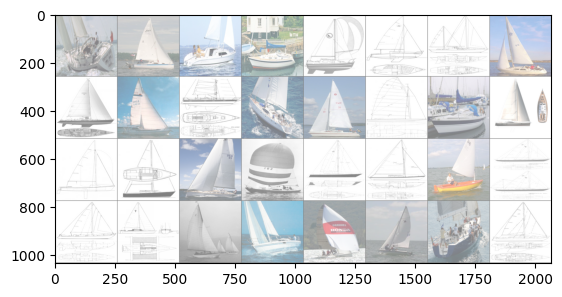

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter._next_data()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [7]:
# for i in range(batch_size):
#   imshow(images[i])
#   #print(classes[labels[i].item()], "\n\n")
#   print(dataset_train.categories[int(labels[i])], "\n\n")

In [8]:
class resNet50(nn.Module):
    def __init__(self , num_classes):
        super(resNet50 , self).__init__()
        self.model_resnet = resnet50(weights=ResNet50_Weights.DEFAULT) # A pretrained resnet 50
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.model_resnet(x)
        x = self.fc1(x)
        return x

In [9]:
class resNet18(nn.Module):
    def __init__(self , num_classes):
        super(resNet18 , self).__init__()
        self.model_resnet = resnet18(weights=ResNet18_Weights.DEFAULT) # A pretrained resnet 18
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.model_resnet(x)
        x = self.fc1(x)
        return x

In [10]:
class baselineNet(nn.Module):
    def __init__(self , num_classes):
        super(baselineNet , self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 2**8)
        self.fc2 = nn.Linear(2**8, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
no_epochs = 2



net_list =[
    baselineNet(len(dataset_train.categories)),
    resNet18(len(dataset_train.categories)),
    resNet50(len(dataset_train.categories))
]

for type in dataset_train.tabular_data.columns:
    dataset_train.label_type = type
    dataset_test.label_type = type

    for net in net_list:
        name = str(net.__class__.__name__)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.95)
        net.to(device)

        writer = SummaryWriter(comment=name+"_"+type)

        # Load the TensorBoard notebook extension
        %load_ext tensorboard
        net.train()
        reporting_interval = 50
        for epoch in range(no_epochs):  # Loop over the dataset multiple times
            epoch_loss = test_loss =  running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # Get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Print statistics
                epoch_loss += loss.item()
                running_loss += loss.item()
                if i % reporting_interval == reporting_interval-1:  # Print every reporting_interval mini-batches
                    print('[%d, %5d] loss: %.3f' %
                        (epoch, i + 1, running_loss / reporting_interval))
                    running_loss = 0.0
            
            # Calculate test loss and log to tensorboard
            net.eval()
            with torch.no_grad():
                for i, data in enumerate(testloader, 0):
                    inputs, labels = data[0].to(device), data[1].to(device)
                    outputs = net(inputs)
                    loss_test = criterion(outputs, labels)
                    test_loss += loss_test.item()


            writer.add_scalar("Loss_train", epoch_loss/(len(trainloader)), epoch)
            writer.add_scalar("Loss_test", test_loss/(len(testloader)), epoch)
            net.train()



        print('Finished Training' , str(net.__class__.__name__)+""+type)
        torch.save(net , name+'_'+type+'.pth')
        writer.flush()

[0,    50] loss: 3.787
[0,   100] loss: 2.953
[0,   150] loss: 2.927


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1,    50] loss: 2.938
[1,   100] loss: 2.885
[1,   150] loss: 2.857


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Finished Training baselineNetHull Type
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
[0,    50] loss: 3.029
[0,   100] loss: 2.657
[0,   150] loss: 2.488


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1,    50] loss: 2.369
[1,   100] loss: 2.246
[1,   150] loss: 2.243


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Finished Training resNet18Hull Type
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
[0,    50] loss: 2.877
[0,   100] loss: 2.575
